In [1]:
import sys

sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)
set_global_pool(cpus=8)

# Setup

In [5]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')

In [6]:
reference = 'c1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCOCCn1ccnc1[N+](=O)[O-]'
scaffold = '*c1ccc2c(*)ncnc2c1'
r1 = '*OCCOCCn1ccnc1[N+](=O)[O-]'
r2 = '*Nc1ccc(F)c(Cl)c1'

scaffold_mapped = '[1*:1]c1ccc2c([1*:2])ncnc2c1'
r1_mapped = '[2*:1]OCCOCCn1ccnc1[N+](=O)[O-]'
r2_mapped = '[2*:2]Nc1ccc(F)c(Cl)c1'

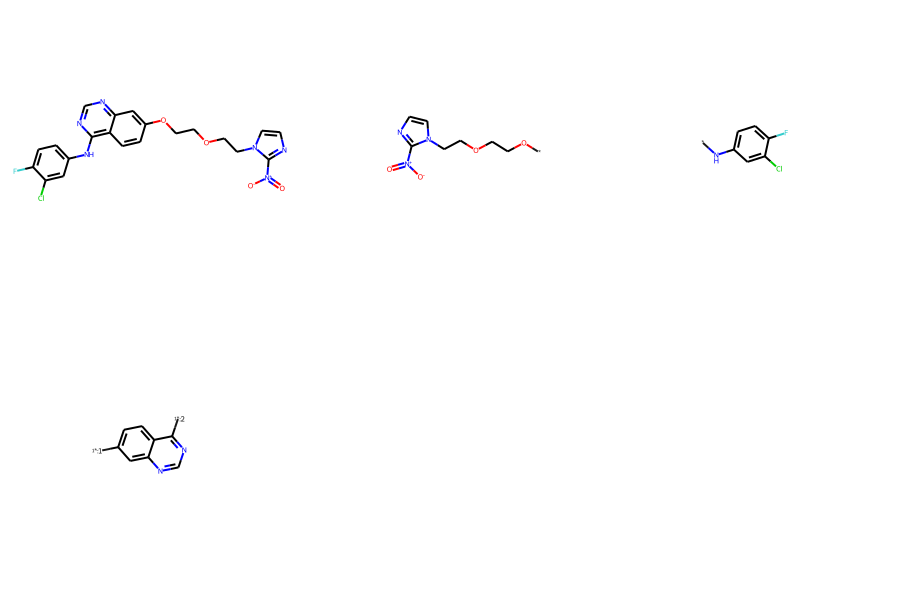

In [7]:
draw_mols(to_mols([reference, r1, r2, scaffold_mapped]))

In [8]:
r1_template = Template(
                    [MolWtFilter(20, 220),
                     RotBondFilter(None, 8),
                     RingFilter(None, 1),],
                    [],
                    fail_score=-1, log=False
                    )

r2_template = Template(
                    [MolWtFilter(20, 220),
                     RotBondFilter(None, 2),
                     RingFilter(None, 1),
                     KeepFilter(['[#0]-[R]',
                                 '[#0]-[*]-[R]'], criteria='any')],
                    [],
                    fail_score=-1, log=False
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 10),
                     HeteroatomFilter(None, 12),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 550),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 10)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template = DoubleRGroupBlockTemplate(scaffold_mapped, r1_template, r2_template, 
                                    full_molecule_template=full_template)

In [10]:
template.recurse_fragments(['[2*:1]OCCOCCn1ccnc1[N+](=O)[O-].[2*:2]Nc1ccc(F)c(Cl)c1'])

[['[2*:1]OCCOCCn1ccnc1[N+](=O)[O-].[2*:2]Nc1ccc(F)c(Cl)c1',
  'O=[N+]([O-])c1nccn1CCOCCOc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1',
  True,
  0.0]]

In [11]:
df = pd.read_csv('/home/dmai/smiles_datasets/single_frags.csv')

In [12]:
df.shape

(5262287, 4)

In [14]:
df['r1_smiles'] = df.smiles.map(lambda x: x.replace('*', '[2*:1]'))

In [15]:
df['r2_smiles'] = df.smiles.map(lambda x: x.replace('*', '[2*:2]'))

In [16]:
df

,smiles,attachments,weight,atoms,r1_smiles,r2_smiles
0,*CCOc1c(O)cc(CNC)cc1F,1,198.093032,14,[2*:1]CCOc1c(O)cc(CNC)cc1F,[2*:2]CCOc1c(O)cc(CNC)cc1F
1,*C(C)Oc1c(O)cc(CNC)cc1F,1,198.093032,14,[2*:1]C(C)Oc1c(O)cc(CNC)cc1F,[2*:2]C(C)Oc1c(O)cc(CNC)cc1F
2,*N(C)Cc1cc(O)c(OCC)c(F)c1,1,198.093032,14,[2*:1]N(C)Cc1cc(O)c(OCC)c(F)c1,[2*:2]N(C)Cc1cc(O)c(OCC)c(F)c1
3,*Oc1cc(CNC)cc(F)c1OCC,1,198.093032,14,[2*:1]Oc1cc(CNC)cc(F)c1OCC,[2*:2]Oc1cc(CNC)cc(F)c1OCC
4,*Oc1cc(O)ncc1C(=O)NCCO,1,197.056232,14,[2*:1]Oc1cc(O)ncc1C(=O)NCCO,[2*:2]Oc1cc(O)ncc1C(=O)NCCO
...,...,...,...,...,...,...
5262282,*C1(C)CC(C(C)c2ccccc2)=NO1,1,188.107539,14,[2*:1]C1(C)CC(C(C)c2ccccc2)=NO1,[2*:2]C1(C)CC(C(C)c2ccccc2)=NO1
5262283,*[N+](CC)(CC)CCCC(=O)[O-],1,158.118104,11,[2*:1][N+](CC)(CC)CCCC(=O)[O-],[2*:2][N+](CC)(CC)CCCC(=O)[O-]
5262284,*C(=NO)C(CN(C)C)=NO,1,144.077302,10,[2*:1]C(=NO)C(CN(C)C)=NO,[2*:2]C(=NO)C(CN(C)C)=NO
5262285,*CC(O)C1OC(O)CC(O)C1O,1,177.076299,12,[2*:1]CC(O)C1OC(O)CC(O)C1O,[2*:2]CC(O)C1OC(O)CC(O)C1O


In [9]:
# set_global_pool(cpus=64)

In [25]:
r1_passes, _ = r1_template.screen_mols(df.r1_smiles.values)
r1_passes = [i[0] for i in r1_passes]

In [26]:
r2_passes, _ = r2_template.screen_mols(df.r2_smiles.values)
r2_passes = [i[0] for i in r2_passes]

In [27]:
len(r1_passes), len(r2_passes)

(3926528, 371196)

In [40]:
passing_dfs = []

for i in range(10):
    print(i)

    r1_sample = np.random.choice(r1_passes, size=150000, replace=False)

    r2_sample = np.random.choice(r2_passes, size=150000, replace=False)

    smiles_inputs = [r1_sample[j]+'.'+r2_sample[j] for j in range(len(r1_sample))]
    
    outputs = template.recurse_fragments(smiles_inputs)
    outputs = pd.DataFrame(outputs, columns=['fragment', 'fused', 'pass', 'score'])
    outputs = outputs[outputs['pass']]
    passing_dfs.append(outputs)

0
1
2
3
4
5
6
7
8
9


In [41]:
passing_dfs = pd.concat(passing_dfs)
passing_dfs.shape

(810778, 4)

In [44]:
passing_dfs.duplicated(subset='fragment').sum()

0

In [45]:
passing_dfs = passing_dfs[['fragment', 'fused']]

In [46]:
passing_dfs.to_csv('double_r_ds.csv', index=False)

In [9]:
passing_dfs = pd.read_csv('double_r_ds.csv')

In [10]:
passing_dfs.fragment.values[0]

'[2*:1]CC(CO)NCC(=O)NCC.[2*:2]c1cc(Cl)sc1C(=O)O'

# Train Model

In [11]:
vocab = CharacterReplaceVocab(SMILES_CHAR_VOCAB, replace_dict={'[2*:1]':'X', '[2*:2]':'Y'})

In [12]:
ds = Text_Dataset(passing_dfs.fragment.values, vocab)

In [13]:
ds[0]

(tensor([ 0, 47, 23, 23,  5, 23, 28,  6, 27, 23, 23,  5, 20, 28,  6, 27, 23, 23,
         43, 48, 34, 11, 34, 34,  5, 23, 36,  6, 40, 34, 11, 23,  5, 20, 28,  6,
         28,  1]),
 None)

In [14]:
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

In [15]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [16]:
agent.train_supervised(800, 10, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.96611,1.08009,03:01
1,0.62393,0.63228,03:00
2,0.52895,0.55729,03:01
3,0.50689,0.53848,03:01
4,0.47141,0.52820,03:00
5,0.51982,0.52371,03:01
6,0.52281,0.51775,03:01
7,0.51415,0.51433,03:00
8,0.50227,0.51172,03:02
9,0.44938,0.51125,03:01


In [17]:
torch.save(agent.model.cpu().state_dict(), '../nbs/untracked_files/lstm_lm_doubleR.pt')
to_device(agent.model)

LSTM_LM(
  (embedding): Embedding(50, 256)
  (lstm): LSTM(
    (input_drop): SequenceDropout()
    (lstm_drop): SequenceDropout()
    (lstms): ModuleList(
      (0): LSTM(256, 1024, batch_first=True)
      (1): LSTM(1024, 1024, batch_first=True)
      (2): LSTM(1024, 256, batch_first=True)
    )
  )
  (head): Linear(in_features=256, out_features=50, bias=True)
)

In [16]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_doubleR.pt'))
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [17]:
preds, _ = model.sample_no_grad(500, 90)
mols = to_mols(agent.reconstruct(preds))
len([i for i in mols if i is not None])/len(mols)

0.978

In [18]:
vocab.reconstruct(preds[2])

'[2*:1]c1cc(C(F)F)c(Cl)nc1N.[2*:2]c1cc(N)ccc1S(=O)(=O)CC'

# RL

In [17]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [18]:
r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/affinity_mlp.pt')

r_model.eval();

freeze(r_model)

reward = Reward(r_agent.predict_data, weight=-10.)

aff_reward = RewardCallback(reward, 'aff')

In [20]:
aff_reward.reward([reference])

tensor(-0.6111, device='cuda:1')

In [21]:
set_global_pool(cpus=8)

In [22]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [23]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [24]:
aff_reward = RewardCallback(reward, 'aff', sample_name='samples_fused')

In [25]:
template_cb = TemplateCallback(template, prefilter=True)

In [26]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

<AxesSubplot:>

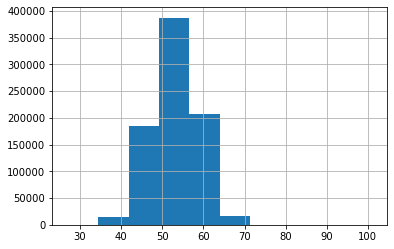

In [30]:
passing_dfs.fragment.map(lambda x: len(x)).hist()

In [28]:
%%time
env.fit(200, 70, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-6.204,-6.204,1.000,1.000,193,0.000,0.965,1.000,0.912,-6.420,1.000,-6.204,0.764,-3.796,-2.858
10,-6.231,-6.231,1.000,1.000,193,0.000,0.965,1.000,0.912,-6.209,1.000,-6.231,0.798,-3.761,-1.344
20,-6.162,-6.162,0.974,1.000,191,0.000,0.955,1.000,0.887,-6.063,1.000,-6.162,0.903,-3.304,-2.073
30,-5.947,-5.947,0.984,1.000,190,0.000,0.950,1.000,0.875,-6.029,1.000,-5.947,0.690,-4.270,-1.140
40,-6.144,-6.144,0.969,1.000,195,0.000,0.975,1.000,0.938,-6.350,1.000,-6.144,0.741,-4.314,-2.913
50,-5.959,-5.959,0.958,1.000,190,0.000,0.950,1.000,0.875,-6.198,1.000,-5.959,0.707,-4.129,-2.566
60,-5.865,-5.865,0.964,1.000,192,0.000,0.960,1.000,0.900,-6.038,1.000,-5.865,0.856,-3.947,-1.172
70,-5.957,-5.957,0.964,1.000,194,0.000,0.970,1.000,0.925,-5.993,1.000,-5.957,0.783,-3.388,-1.577
80,-5.991,-5.991,0.969,1.000,192,0.000,0.960,1.000,0.900,-6.008,1.000,-5.991,0.806,-3.429,-1.946
90,-5.865,-5.865,0.954,1.000,195,0.000,0.975,1.000,0.938,-6.276,1.000,-5.865,0.928,-3.647,-1.153


Epoch,Train Loss,Valid Loss,Time
0,1.73042,1.81044,00:00


Epoch,Train Loss,Valid Loss,Time
0,1.53332,1.65820,00:00


Epoch,Train Loss,Valid Loss,Time
0,1.46013,1.46689,00:01


Epoch,Train Loss,Valid Loss,Time
0,1.19624,1.43928,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.94156,1.10579,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.84559,0.83649,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.88776,0.82392,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.84642,0.81465,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.68503,0.65928,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.64171,0.65474,00:02


CPU times: user 8h 54min 58s, sys: 9min 50s, total: 9h 4min 49s
Wall time: 40min 48s


Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-29:
Process ForkPoolWorker-63:
Process ForkPoolWorker-31:
Process ForkPoolWorker-57:
Process ForkPoolWorker-61:
Process ForkPoolWorker-60:
Process ForkPoolWorker-58:
Process ForkPoolWorker-62:
Process ForkPoolWorker-28:
Process ForkPoolWorker-64:
Process ForkPoolWorker-30:
Process ForkPoolWorker-27:
Process ForkPoolWorker-59:
Process ForkPoolWorker-32:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File 

  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with s

In [42]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_doubleR.pt'))
agent.update_dataset_from_inputs(env.log.df[env.log.df.aff>-3].samples.values)
agent.train_supervised(128, 4, 1e-4)
agent.update_dataset_from_inputs(env.log.df[env.log.df.aff>-1].samples.values)
agent.train_supervised(128, 3, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.68351,0.76547,00:06
1,0.65488,0.65858,00:06
2,0.60820,0.64426,00:06
3,0.60269,0.64177,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.59176,0.58267,00:00
1,0.61614,0.58039,00:00
2,0.60741,0.58004,00:00


<All keys matched successfully>

In [44]:
len(env.buffer.buffer)

1046

In [46]:
refresh_global_pool()

In [47]:
%%time
env.fit(200, 70, 2000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,-3.179,-3.179,0.723,1.000,47,0.000,0.235,1.000,0.225,-2.760,1.000,-3.179,1.009,-0.711,0.114
2010,-2.822,-2.822,0.841,1.000,145,0.000,0.725,1.000,0.312,-2.698,1.000,-2.822,0.777,-0.405,0.184
2020,-3.077,-3.077,0.833,1.000,138,0.000,0.690,1.000,0.225,-3.586,1.000,-3.077,0.974,-1.897,-0.133
2030,-2.851,-2.851,0.807,1.000,140,0.000,0.700,1.000,0.250,-2.302,1.000,-2.851,1.025,-0.707,-0.159
2040,-2.907,-2.907,0.829,1.000,140,0.000,0.700,1.000,0.250,-2.772,0.950,-2.907,0.916,-0.125,0.305
2050,-2.770,-2.770,0.881,1.000,151,0.000,0.755,1.000,0.388,-3.448,1.000,-2.770,1.038,-0.282,0.453
2060,-3.237,-3.237,0.857,1.000,133,0.000,0.665,1.000,0.163,-3.868,1.000,-3.237,1.142,-0.377,0.063
2070,-2.865,-2.865,0.877,1.000,138,0.000,0.690,1.000,0.225,-3.737,1.000,-2.865,1.003,-0.325,0.377
2080,-2.827,-2.827,0.871,1.000,140,0.000,0.700,1.000,0.250,-3.731,1.000,-2.827,0.790,-1.556,-0.195
2090,-2.570,-2.570,0.850,1.000,140,0.000,0.700,1.000,0.250,-3.243,1.000,-2.570,0.811,-0.886,-0.185


Epoch,Train Loss,Valid Loss,Time
0,0.55975,0.49502,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.42514,0.47422,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.37767,0.33876,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.28906,0.35515,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.28131,0.27155,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.27051,0.26329,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.26234,0.28868,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24319,0.30204,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24418,0.23294,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.21857,0.35060,00:04


CPU times: user 8h 12min 41s, sys: 9min 4s, total: 8h 21min 46s
Wall time: 27min 23s


In [51]:
%%time
env.fit(200, 70, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
4000,0.808,0.808,0.321,0.995,187,0.000,0.935,1.000,0.838,0.819,0.224,0.808,0.030,1.192,1.316
4010,0.791,0.791,0.411,1.000,192,0.000,0.960,1.000,0.900,0.892,0.236,0.791,0.033,1.229,1.302
4020,0.812,0.812,0.347,0.979,190,0.000,0.950,0.957,0.875,0.878,0.200,0.812,0.028,1.241,1.312
4030,0.780,0.780,0.330,0.984,188,0.000,0.940,0.956,0.850,0.788,0.191,0.780,0.039,1.178,1.323
4040,0.814,0.814,0.309,0.984,191,0.000,0.955,0.958,0.887,0.895,0.099,0.814,0.055,1.230,1.348
4050,0.762,0.762,0.360,1.000,186,0.000,0.930,1.000,0.825,0.729,0.182,0.762,0.046,1.196,1.376
4060,0.784,0.784,0.287,0.989,188,0.000,0.940,0.985,0.850,0.895,0.118,0.784,0.038,1.197,1.358
4070,0.842,0.842,0.280,0.978,186,0.000,0.930,0.970,0.825,0.912,0.121,0.842,0.042,1.249,1.358
4080,0.848,0.848,0.283,0.963,191,0.000,0.955,0.958,0.887,0.961,0.113,0.848,0.053,1.302,1.358
4090,0.796,0.796,0.279,0.979,190,0.000,0.950,1.000,0.875,0.845,0.129,0.796,0.060,1.233,1.323


Epoch,Train Loss,Valid Loss,Time
0,0.24109,0.25449,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.24518,0.25140,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.26897,0.24853,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.26198,0.25983,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.25108,0.23056,00:04


CPU times: user 4h 9min 37s, sys: 4min 30s, total: 4h 14min 7s
Wall time: 12min 29s


In [65]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_doubleR.pt'))
agent.update_dataset_from_inputs(env.log.df[env.log.df.aff>.6].samples.values)
agent.train_supervised(128, 3, 1e-4)
agent.update_dataset_from_inputs(env.log.df[env.log.df.aff>1].samples.values)
agent.train_supervised(128, 3, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.30859,0.31596,00:18
1,0.28116,0.29553,00:18
2,0.29770,0.29258,00:18


Epoch,Train Loss,Valid Loss,Time
0,0.27155,0.26584,00:04
1,0.27064,0.26330,00:04
2,0.25636,0.26106,00:04


<All keys matched successfully>

In [66]:
%%time
env.fit(200, 70, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
5000,0.932,0.932,0.286,1.000,192,0.000,0.960,1.000,0.900,0.968,0.292,0.932,0.025,1.247,1.460
5010,0.912,0.912,0.337,1.000,190,0.000,0.950,1.000,0.875,0.931,0.214,0.912,0.052,1.248,1.406
5020,0.922,0.922,0.332,1.000,190,0.000,0.950,1.000,0.875,0.937,0.214,0.922,0.038,1.258,1.324
5030,0.921,0.921,0.340,1.000,194,0.000,0.970,1.000,0.925,0.978,0.257,0.921,0.010,1.268,1.359
5040,0.937,0.937,0.337,1.000,190,0.000,0.950,1.000,0.875,0.992,0.286,0.937,0.048,1.276,1.461
5050,0.979,0.979,0.349,1.000,189,0.000,0.945,1.000,0.863,1.003,0.261,0.979,0.010,1.322,1.422
5060,0.939,0.939,0.384,1.000,190,0.000,0.950,1.000,0.875,0.897,0.357,0.939,0.018,1.266,1.369
5070,0.925,0.925,0.326,0.989,190,0.000,0.950,1.000,0.875,1.029,0.171,0.925,0.032,1.259,1.344
5080,0.991,0.991,0.376,0.995,194,0.000,0.970,1.000,0.925,1.015,0.351,0.991,0.010,1.299,1.422
5090,0.982,0.982,0.392,0.985,194,0.000,0.970,0.973,0.925,0.953,0.351,0.982,0.020,1.278,1.383


Epoch,Train Loss,Valid Loss,Time
0,0.25498,0.23628,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.24299,0.23724,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.26366,0.26668,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.25062,0.25156,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.27237,0.25397,00:05


CPU times: user 4h 10min 45s, sys: 4min 35s, total: 4h 15min 20s
Wall time: 12min 58s


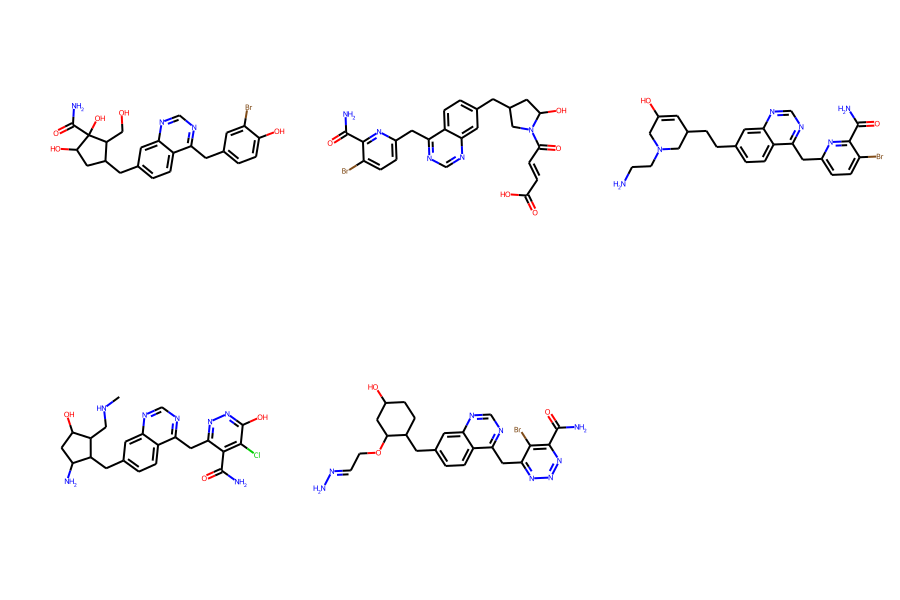

In [70]:
draw_mols(to_mols(env.log.df[env.log.df.rewards>1.55].samples_fused.values))

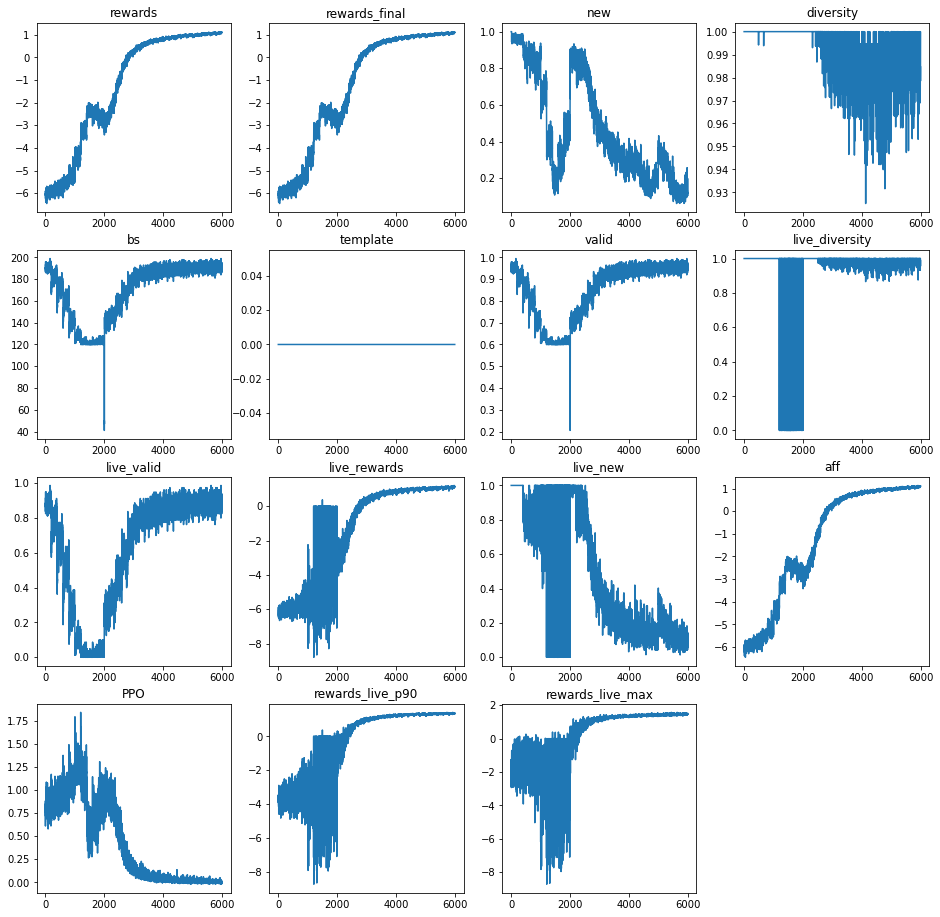

In [71]:
env.log.plot_metrics()